In [1]:
from typing import Tuple, List, Dict, Any

import pandas as pd
import random
import re

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import load_word2vec_format

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
SEED = 2222

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1 Input representation: pretrained word embeddings

To process the tweet inputs and make predictions, your classifiers need a numerical representation of these inputs. In this assignment, you'll use word embeddings to represent the words in the input tweets. We are going to use embeddings from the **word2vec** Google News pretrained model. This is an embedding model that contains 300-dimensional vectors for 3 million words and phrases.

We're providing a download link here to the pretrained word embeddings, so you can easily start working with them:

In [2]:
"""import gdown
import zipfile

# Google Drive direct download link
url = 'https://drive.google.com/uc?id=1zQRH1zYBHJ_vU_uMkKvvvwQiZwP5N7wW'

# Destination file name
output = 'NLP_DATA.zip'

# Download the file
gdown.download(url, output, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(output, 'r') as zip_ref:
     zip_ref.extractall('.')"""

"import gdown\nimport zipfile\n\n# Google Drive direct download link\nurl = 'https://drive.google.com/uc?id=1zQRH1zYBHJ_vU_uMkKvvvwQiZwP5N7wW'\n\n# Destination file name\noutput = 'NLP_DATA.zip'\n\n# Download the file\ngdown.download(url, output, quiet=False)\n\n# Unzip the downloaded file\nwith zipfile.ZipFile(output, 'r') as zip_ref:\n     zip_ref.extractall('.')"

In [3]:
# Load embeddings model to use in the assignment
w2v_model = load_word2vec_format("./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary = True)

# 3 Preprocessing the data and loading it

Now that you feel familiar with how the word2vec model works, let's create some functions that would be in charge of the preprocessing of the data. You are free to perform any operation you feel right to preprocess the data.


## 3.1. Tweet tokenization

Let's start with some form of **tokenization** on the tweets. That is, write a tokenizer that, given tweet, splitting the text into words, and performs any text normalization you find suitable.

For this, we suggest that you define a function `tokenize_tweet` which takes a sentence as a string, and returns the tokenized sentence.


In [4]:
def tokenize_tweet(tweet: str) -> List[str]:
  """
    Tokenizes a given tweet by splitting the text into words, and doing any cleaning, replacing or normalization deemed useful

    Args:
        tweet (str): The tweet text to be tokenized.

    Returns:
        list[str]: A list of strings, representing the tokenized components of the tweet.
  """
  # TODO: Complete the tokenize_tweet function
  # replace the usernas with a specific token
  global USR_MENTION_TOKEN
  global URL_TOKEN
  USR_MENTION_TOKEN = "<!USR_MENTION>"
  URL_TOKEN = "<!URL>"
  tweet = re.sub(r'@\w+', USR_MENTION_TOKEN, tweet)
  
  # replace the urls with a specific token
  tweet = re.sub(r'http\S+', URL_TOKEN, tweet)
  
  # remove the hashtags from the tweet
  tweet = re.sub(r'#\w+', '', tweet)
  
  return tweet.split()

## 3.2. Load data for training, validation and test dataset

Next, you'll need to load the data, which is placed in the `data` subfolder.

Write a `load_data` function that takes a path to one of the data files, such as `/content/NLP_Data/data/train.csv`.

Calling load data with that file path should return the tokenized texts and their corresponding labels. Here's how it may look:

 ```

 tr_texts, tr_targets = load_data('/content/NLP_Data/data/train.csv')

 # Checking the first training text and label

print(tr_texts[0], tr_targets[0])

['YEA', 'now', 'that', 'note', 'GOOD'], 1


 ```

In [5]:
def load_data(file_path: str) -> Tuple[List[List[str]], List[int]]:
    """
    Load data from a specified file path, extract texts and targets, and tokenize the texts using the tokenize_tweet function.

    Parameters:
    file_path (str): The path to the dataset file.

    Returns:
    Tuple[List[str], List[int]]: Lists of texts and corresponding targets.
    """
    try:
        # TODO: Read the corresponding csv
        data: pd.DataFrame = pd.read_csv(file_path) 

        # TODO: Obtain the text column from data
        texts: List[str] = data['text'].tolist()
                
        # TODO: Obtain targets, 0 for human and 1 for bot
        # replace the target column with a binary representation
        data['tag'] = data['account.type'].replace('human', 0)
        data['tag'] = data['tag'].replace('bot', 1)
        targets: List[int] = data['tag'].tolist()     
        
        # TODO: Return tokenized texts, and targets
        return [tokenize_tweet(text) for text in texts], targets
    
    except FileNotFoundError:
        print(f"{file_path} not found. Please check the file path.")


In [6]:
# Load datasets
tr_texts, tr_targets = load_data('./NLP_Data/data/train.csv')
vl_texts, vl_targets = load_data('./NLP_Data/data/validation.csv')
ts_texts, ts_targets = load_data('./NLP_Data/data/test.csv')

## 3.3 Preparing dataset

Next, put your inputs and targets into a PyTorch `Dataset` object, which we'll use for training.

Define a `Dataset` class called `TweepFakeDataset(Dataset)`, which takes the tokenized tweets and labels, that we will later pass to a `DataLoader`.

In [7]:
class TweepFakeDataset(Dataset):
    """
    A PyTorch Dataset for the TweepFake dataset.

    Attributes:
        texts (List[List[str]]): List of tweets tokens.
        targets (List[str]): List of target labels.
    """

    def __init__(self,
                 texts: List[List[str]],
                 targets: List[int]
                 ):
        """
        Initializes the TweepFakeDataset with the given file path.

        Args:
            texts (List[List[str]]): List of tweets tokens.
            targets (List[str]): List of target labels.
        """
        # TODO: Complete the init function
        # initialise the super class
        super().__init__()
        self.texts = texts
        self.targets = targets
        self._len = len(self.texts) 

    def __len__(self) -> int:
        """Returns the length of the dataset."""
        # TODO: Complete the len function
        return self._len # VALID IF WE DONT UPDATE THE DATASET, OTHERWISE WOULD NEED TO IMPLEMENT AN _update_len METHOD

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the embedded tensor and target for the text at the specified index.

        Args:
            idx (int): Index of the item.

        Returns:
            Tuple[List[str], List[int]]: A tuple containing the BoW vector and the target label.
        """
        # TODO: Complete the getitem function
        
        return self.texts[idx], self.targets[idx]

In [8]:
# TODO: Create datasets for models
tr_dataset = TweepFakeDataset(tr_texts, tr_targets)
vl_dataset = TweepFakeDataset(vl_texts, vl_targets)
ts_dataset = TweepFakeDataset(ts_texts, ts_targets)

## 3.4 Auxiliary functions

In this section, you'll prepare a few auxiliary function which we'll be used for training.

In [9]:
def word2idx(embedding_model: Any, tweet: List[str]) -> torch.Tensor:
    """
    Converts a tweet to a list of word indices based on an embedding model.

    This function iterates through each word in the tweet and retrieves its corresponding index
    from the embedding model's vocabulary. If a word is not present in the model's vocabulary,
    it is skipped.

    Args:
        embedding_model (Any): The embedding model with a 'key_to_index' attribute, which maps words to their indices.
        tweet (List[str]): A list of words representing the tweet.

    Returns:
        torch.Tensor: A tensor of word indices corresponding to the words in the tweet.
    """
    # TODO: Complete the function according to the requirements
    
    # get the indices of the words in the tweet
    indices = [embedding_model.key_to_index[word] for word in tweet if word in embedding_model.key_to_index]
    
    return torch.tensor(indices)
    
    

For the following function, you might want to check the [pad_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) function.

In [10]:
from typing import Tuple, List, Dict, Any
def collate_fn(batch: List[Tuple[List[str], int]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepares and returns a batch for training/testing in a torch model.

    This function sorts the batch by the length of the text sequences in descending order,
    tokenizes the text using a pre-defined word-to-index mapping, pads the sequences to have
    uniform length, and converts labels to tensor.

    Args:
        batch (List[Tuple[List[str], int]]): A list of tuples, where each tuple contains a
                                             list of words (representing a text) and an integer label.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing three elements:
            - texts_padded (torch.Tensor): A tensor of padded word indices of the text.
            - labels (torch.Tensor): A tensor of labels.
            - lengths (torch.Tensor): A tensor representing the lengths of each text sequence.
    """
    # TODO: Sort the batch by the length of text sequences in descending order
    
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    
    # TODO: Unzip texts and labels from the sorted batch
    texts: List[str]
    labels: List[int]
    texts, labels = zip(*batch)
    
    # convert the elements of the labels list to int
    labels = list(labels)
    labels = [int(label) for label in labels]
    
    # TODO: Convert texts to indices using the word2idx function and w2v_model
    texts_indx: List[torch.Tensor] = [word2idx(w2v_model, tweet) for tweet in texts]

    # TODO: Calculate the lengths of each element of texts_indx.
    # The minimum length shall be 1, in order to avoid later problems when training the RNN
    lengths: List[torch.Tensor] = [max(len(tweet), 1) for tweet in texts_indx]

    # TODO: Pad the text sequences to have uniform length
    texts_padded: torch.Tensor = pad_sequence(texts_indx, batch_first=True)

    # TODO: Convert labels to tensor
    labels: torch.Tensor = torch.tensor(labels)

    return texts_padded, labels, lengths

In [11]:
def calculate_accuracy(model: torch.nn.Module, dataloader: DataLoader, threshold: float = 0.5, device: str = 'cpu') -> float:
    """
    Calculate the accuracy of a PyTorch model given a DataLoader.

    The function moves the model to the specified device, sets it to evaluation mode, and computes
    the accuracy by comparing the model's predictions against the true labels. The predictions are
    determined based on a specified threshold.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        dataloader (DataLoader): The DataLoader containing the dataset to evaluate against.
        threshold (float, optional): Probability threshold to predict a sample as positive. Defaults to 0.5.
        device (str, optional): Device to which the model and data are moved ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
        float: The accuracy of the model on the given dataset.
    """
    # TODO: Calculate accuracy of a model given a dataloader
    accuracy = None
    
    # move the model to the device
    model.to(device)
    
    # set the model to evaluation mode
    model.eval()
    
    # initialise the number of correct predictions
    correct = 0
    
    # iterate through the dataloader
    for texts, labels, lengths in dataloader:
        texts, labels = texts.to(device), labels.to(device)
        
        # get the model's predictions
        predictions = model(texts, lengths)
        
        # convert the predictions to binary
        predictions = (predictions > threshold).float()
        
        # calculate the number of correct predictions
        correct += (predictions == labels).sum().item()
        
    # calculate the accuracy
    accuracy = correct / len(dataloader.dataset)
    
    return accuracy

# 4 Train loop

It's time to define the training loop. You'll end up training three types of models, Logistic Regression, MLP classifier and RNN classifier. However, we want to use the same training loop function for all of them.

Let's define a function `train_torch_model` to do so.

In [12]:
def train_torch_model(model: torch.nn.Module, 
                        train_dataloader: DataLoader,
                        val_dataloader: DataLoader, 
                        criterion: nn.Module,
                        optimizer: optim.Optimizer, 
                        epochs: int,
                        print_every: int, 
                        patience: int,
                        device: str = 'cpu'
                    ) -> Tuple[Dict[int, float],Dict[int, float]]:
    """
    Train and validate the logistic regression model.

    Args:
        model (torch.nn.Module): An instance of the model to be trained.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        val_dataloader (DataLoader): DataLoader for the validation dataset.
        learning_rate (float): The learning rate for the optimizer.
        criterion (nn.Module): Loss function to use for training.
        optimizer (optim.Optimizer): Optimizer to use for training.
        epochs (int): The number of epochs to train the model.
        print_every (int): Frequency of epochs to print training and validation loss.
        patience (int): The number of epochs to wait for improvement on the validation loss before stopping training early.
        device (str): device where to train the model.

    Returns:
        Tuple[Dict[int, float],Dict[int, float]]: Dictionary of accuracies at each `print_every` interval for the training and validation datasets.
    """
    # TODO: Initialize dictionaries to store training and validation accuracies
    train_accuracies: Dict[int, float] = {} # epoch: accuracy
    val_accuracies: Dict[int, float] = {} # epoch: accuracy

    # TODO: Initialize variables for Early Stopping
    best_loss: float = float('inf')
    epochs_no_improve: int = 0


    # TODO: Move the model to the specified device (CPU or GPU)
    model.to(device)


    # TODO: Implement the training loop over the specified number of epochs
    for epoch in range(epochs):
        # TODO: Set the model to training mode
        model.train()
        
        total_loss: float = 0.0

        # TODO: Implement the loop for training over each batch in the training dataloader
        for features, labels, text_len in train_dataloader:
            
            # TODO: Move features and labels to the specified device
            features, labels = features.to(device), labels.to(device)

            # TODO: Clear the gradients
            optimizer.zero_grad()

            # TODO: Forward pass (compute the model output)
            output = model(features, text_len)

            # TODO: Compute the loss
            # cast labels to float to avoid a data type mismatch error
            loss = criterion(output, labels.float())

            # TODO: Backward pass (compute the gradients)
            loss.backward()

            # TODO: Update model parameters
            optimizer.step()

            # TODO: Accumulate the loss
            total_loss += loss.item()


        # TODO: Implement the evaluation phase
        model.eval()
        val_loss: float = 0.0
        
        with torch.no_grad():
            # TODO: Loop over the validation dataloader
            for features, labels, text_len in val_dataloader:
                
                # TODO: Move features and labels to the specified device
                features, labels = features.to(device), labels.to(device)

                # TODO: Forward pass (compute the model output)
                output = model(features, text_len)

                # TODO: Compute the loss
                loss = criterion(output, labels.float())

                # TODO: Accumulate validation loss
                val_loss += loss.item()


        # TODO: Calculate training and validation accuracy
        train_accuracy = calculate_accuracy(model, train_dataloader, device=device)
        val_accuracy = calculate_accuracy(model, val_dataloader, device=device)

        # TODO: Store accuracies
        train_accuracies[epoch] = train_accuracy
        val_accuracies[epoch] = val_accuracy
        
        # TODO: Print training and validation results every 'print_every' epochs
        if epoch % print_every == 0 or epoch == epochs - 1:
            # TODO: Calculate and print average losses and accuracies
            avg_train_loss = total_loss / len(train_dataloader)
            avg_val_loss = val_loss / len(val_dataloader)
            print(f"Epoch {epoch} -> \
                    Train Loss: {avg_train_loss:.4f}, \
                    Val Loss: {avg_val_loss:.4f}, \
                    Train Acc: {train_accuracy:.4f}, \
                    Val Acc: {val_accuracy:.4f}")

        # TODO: Implement Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at epoch {epoch}")
                break
            
        

    return train_accuracies, val_accuracies

# 5 Models

All model will use the embeddings from the `word2vec` model as their first layer, to translate the indexes prepared by the `collate_fn` function to their corresponding embedding vectors. Therefore, the first thing we should do is to extract the embedding layer from the `vectors` attribute of the `word2vec` model.

In [13]:
# TODO: Obtain embedding weights
embedding_weights = torch.FloatTensor(w2v_model.vectors)

## 5.2. Recurrent models: LSTM Classifier

Before diving into the definition of this model, check this [tutorial](https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec) and make sure you understand all the steps there. You will have to use the [pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) in order to be able to handle the padded embeddings.


### 5.2.1 Define the model


In [14]:
class RNN(nn.Module):
    """
    A Recurrent Neural Network (RNN) model implemented using PyTorch for text classification.

    This model utilizes an embedding layer with pre-trained weights, followed by an LSTM layer
    for processing sequential data, and a linear layer for classification.

    Attributes:
        embedding (nn.Embedding): Embedding layer initialized with pre-trained weights.
        rnn (nn.LSTM): LSTM (Long Short Term Memory) layer for processing sequential data.
        fc (nn.Linear): Linear layer for classification.

    Args:
        embedding_weights (torch.Tensor): Pre-trained word embeddings.
        hidden_dim (int): The number of features in the hidden state of the LSTM.
        num_layers (int): The number of layers in the LSTM.
    """

    def __init__(self, embedding_weights: torch.Tensor, hidden_dim: int, num_layers: int):
        """
        Initializes the RNN model with given embedding weights, hidden dimension, and number of layers.

        Args:
            embedding_weights (torch.Tensor): The pre-trained embedding weights to be used in the embedding layer.
            hidden_dim (int): The size of the hidden state in the LSTM layer.
            num_layers (int): The number of layers in the LSTM.
        """
        super().__init__()
        # TODO: Determine the embedding dimension from the embedding weights
        embedding_dim: int = embedding_weights.shape[1]

        # TODO: Create an embedding layer with the given pre-trained weights, use the Embedding.from_pretrained function
        self.embedding: nn.Embedding = nn.Embedding.from_pretrained(embedding_weights)

        # TODO: Initialize the LSTM layer
        self.rnn: nn.RNN = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # TODO: Create a linear layer for classification
        self.fc: nn.Linear = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor, text_lengths: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the RNN model.

        Args:
            x (torch.Tensor): The input tensor containing word indices.
            text_lengths (torch.Tensor): Tensor containing the lengths of texts in the batch.

        Returns:
            torch.Tensor: The output tensor after passing through the model.
        """
        # TODO: Embed the input text using the embedding layer
        embedded: torch.Tensor = self.embedding(x)

        # TODO: Pack the embedded text for efficient processing in the RNN
        packed_embedded: torch.nn.utils.rnn.PackedSequence = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)

        # TODO: Pass the packed sequence through the RNN
        packed_output, hidden = self.rnn(packed_embedded)

        # TODO: Use the last hidden state for classification
        hidden: torch.Tensor = hidden[-1]

        # TODO: Return the final output after passing it through the linear layer
        return self.fc(hidden).squeeze(1)

### 5.2.2 Load the data

In [15]:
# TODO: Define configuration for MLP Classifier training
batch_size: int = 64
epochs: int = 40
print_every: int = 5
patience: int = 20
learning_rate: float = 1e-4
hidden_dim: int = 256
num_layers: int = 2

"""
#! CURRENT BEST MODEL:
    hidden_dim: int = 256
    batch_size: int = 64
    epochs: int = 40
    print_every: int = 5
    patience: int = 20
    learning_rate: float = 1e-4
    hidden_dim: int = 256
    num_layers: int = 2
"""

# TODO: Check if GPU is available and move the model to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on {device}")

Training on cuda


In [16]:
# TODO: Create data loaders with specified batch_size, shuffle the training dataloader
rnn_train_dataloader: DataLoader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
rnn_val_dataloader: DataLoader = DataLoader(vl_dataset, batch_size=batch_size, collate_fn=collate_fn)
rnn_test_dataloader: DataLoader = DataLoader(ts_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [17]:
# TODO: Instantiate the RNN classifier model
rnn_model: RNN = RNN(embedding_weights, hidden_dim, num_layers)

In [18]:
# TODO: Define suitable loss criterion and optimizer
rnn_criterion = nn.BCEWithLogitsLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

### 5.2.3 Train the model and plot the accuracies

In [19]:
# TODO: Train RNN classifier model
rnn_train_accuracies, rnn_val_accuracies = train_torch_model(rnn_model, rnn_train_dataloader,
                                                             rnn_val_dataloader, rnn_criterion,
                                                             rnn_optimizer, epochs, print_every,
                                                             patience=patience, device=device)

Epoch 0 ->                     Train Loss: 0.6411,                     Val Loss: 0.5928,                     Train Acc: 0.6624,                     Val Acc: 0.6503
Epoch 5 ->                     Train Loss: 0.5395,                     Val Loss: 0.5824,                     Train Acc: 0.7233,                     Val Acc: 0.6772
Epoch 10 ->                     Train Loss: 0.5081,                     Val Loss: 0.5837,                     Train Acc: 0.7354,                     Val Acc: 0.6612
Epoch 15 ->                     Train Loss: 0.4801,                     Val Loss: 0.6046,                     Train Acc: 0.7651,                     Val Acc: 0.6785
Epoch 20 ->                     Train Loss: 0.4561,                     Val Loss: 0.6154,                     Train Acc: 0.7848,                     Val Acc: 0.6716
Early stopping at epoch 21


In [20]:
# TODO: Print accuracy for training, validation and test datasets
rnn_accuracy_train = calculate_accuracy(rnn_model, rnn_train_dataloader, device=device)
rnn_accuracy_val = calculate_accuracy(rnn_model, rnn_val_dataloader, device=device)
rnn_accuracy_test = calculate_accuracy(rnn_model, rnn_test_dataloader, device=device)

print(f"RNN Model - Training Accuracy: {rnn_accuracy_train}")
print(f"RNN Model - Validation Accuracy: {rnn_accuracy_val}")
print(f"RNN Model - Test Accuracy: {rnn_accuracy_test}")

RNN Model - Training Accuracy: 0.7867419853225184
RNN Model - Validation Accuracy: 0.6689834926151172
RNN Model - Test Accuracy: 0.6606724003127443


In [21]:
rnn_train_accuracies

{0: 0.662369640787949,
 1: 0.6799439938200077,
 2: 0.6933661645422943,
 3: 0.66039011201236,
 4: 0.7123406720741599,
 5: 0.7232522209347239,
 6: 0.7214658169177288,
 7: 0.7227211278485902,
 8: 0.7250869061413673,
 9: 0.7317014291232136,
 10: 0.7353707995365005,
 11: 0.7379297025878717,
 12: 0.7413576670529162,
 13: 0.7221900347624566,
 14: 0.7366743916570104,
 15: 0.765063731170336,
 16: 0.7421301660872924,
 17: 0.7591734260332175,
 18: 0.7681537273078408,
 19: 0.7738991888760139,
 20: 0.7847624565469293,
 21: 0.7867419853225184}

In [22]:
# Obtain epochs where accuracy was calculated in order to plot them
rnn_epochs, rnn_train_accuracies = zip(*sorted(rnn_train_accuracies.items()))
_, rnn_val_accuracies = zip(*sorted(rnn_val_accuracies.items()))

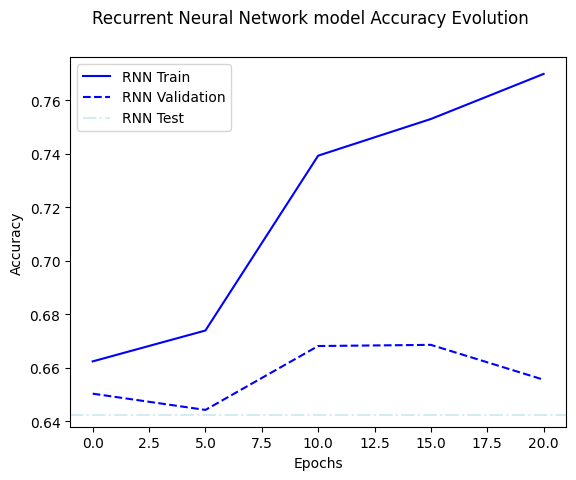

In [23]:
# Plot the evolution during training
plt.plot(rnn_epochs, rnn_train_accuracies, label='RNN Train', linestyle='-', color='blue')
plt.plot(rnn_epochs, rnn_val_accuracies, label='RNN Validation', linestyle='--', color='blue')
plt.axhline(y=rnn_accuracy_test, label='RNN Test', linestyle='-.', color='lightblue', alpha=0.5)
plt.suptitle('Recurrent Neural Network model Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
import os
from torch.jit import RecursiveScriptModule

def save_model(model: torch.nn.Module, name: str) -> None:
    """
    This function saves a model in the 'models' folder as a torch.jit.
    It should create the 'models' if it doesn't already exist.

    Args:
        model: pytorch model.
        name: name of the model (without the extension, e.g. name.pt).
    """

    # create folder if it does not exist
    if not os.path.isdir("models"):
        os.makedirs("models")

    # save scripted model
    model_scripted: RecursiveScriptModule = torch.jit.script(model.cpu())
    model_scripted.save(f"models/{name}.pt")

    return None

In [25]:
# model name
model_name = model_name = f"rnn_hidden_{hidden_dim}_lr_{learning_rate}_epochs_{epochs}" + \
    f"_batch_{batch_size}_patience_{patience}_layers_{num_layers}"
    
# save the model
save_model(rnn_model, model_name)
